In [1]:
#@title Colab Imports
import sys
import madi
from madi.utils import file_utils
import numpy as np
import pandas as pd
from typing import List, Dict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns

from madi.datasets import gaussian_mixture_dataset
from madi.detectors.neg_sample_neural_net_detector import NegativeSamplingNeuralNetworkAD
from madi.detectors.integrated_gradients_interpreter import IntegratedGradientsInterpreter

import tensorflow as tf
assert tf.version.VERSION > '2.1.0'


In [2]:
#@title Plotting utilities
def plot_attribution(df_attribution: pd.DataFrame, anomaly_score: float) -> None:
  """Plots the attribution as a pie chart.

  The center contains the anmomaly score. The wedges are ordered clockwise
  from the most blame to the least. The percentages are the normalized
  percentages (Blame(d) / Sum of Blames). The values outside the wedges
  indicate the observed value, and the expected value in parentheses.

  Args:
    df_attribution: dataframe with observed_value, expected_value, and
    attribution for each dimension.
    anomaly_score: score ranging between Normal (1) and Anomalous (0).

  """
  df_attribution = df_attribution.sort_values(by='attribution', ascending=False)
  norm = plt.Normalize()
  names=[]
  sizes = []
  sum_big = 0
  for fn, row in df_attribution.iterrows():
    # Only show the dimensions with a blame > 5%.
    if row.attribution > 0.05:
      names.append('%s\n%3.1f (%3.1f)' %(fn, row.observed_value, row.expected_value))
      wedge_size = int(100* row.attribution)
      sum_big += wedge_size
      sizes.append(wedge_size)
  names.append('other')
  sizes.append(int(100 - sum_big))

  # Create a circle for the center of the plot
  num_p_score_steps = 100
  center_color_index  = int(num_p_score_steps*anomaly_score)
  my_circle=plt.Circle( (0,0), 0.45, facecolor=plt.cm.RdYlGn(
      norm(range(num_p_score_steps+1)))[center_color_index],
      edgecolor='white', linewidth=3)

  fig, ax = plt.subplots()
  fig.set_figheight(10)
  fig.set_figwidth(10)

  center_text = "%.2f" %(anomaly_score)
  if (center_color_index < 20 ) or (center_color_index > 80):
    text_color = 'white'
  else:
    text_color = 'black'
  ax.text(0,0,center_text, fontsize=28,horizontalalignment='center',
          color=text_color, weight="bold")

  # Custom colors --> colors will cycle
  norm = plt.Normalize()
  # Choose nine colors to cycle through to show contrast between slices.
  pie_plot = plt.pie(sizes, labels=names, colors=plt.cm.RdYlBu(norm(range(9)), alpha=0.6),
                     startangle=90, counterclock=False, autopct='%1.0f%%',
                     pctdistance=0.70, textprops=
                     dict(color="black", weight="bold", fontsize=28))

  for lab in pie_plot[1]:
    lab.set_fontsize(28)
  p=plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()

def plot_gradient_series(df_grad: pd.DataFrame, delta: np.array) -> None:
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(15)
    n_points = len(df_grad)
    colors = sns.color_palette('rainbow', df_grad.shape[1])
    for ix, field_name in enumerate(df_grad):
      series_color = colors[ix]
      ig_series = (df_grad[field_name].cumsum()/float(n_points)) * delta[field_name]
      ax.plot(df_grad.index, ig_series , linewidth=3.0, linestyle='-', marker=None, color=series_color)

    ax.grid(linestyle='-', linewidth='0.5', color='darkgray')

    legend = plt.legend(loc='upper left', shadow=False, fontsize='16', bbox_to_anchor=(1, 1), labels = list(df_grad))
    legend.get_frame().set_facecolor('white')
    plt.ylabel('Cumulative Gradients')

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(24)

    for sp in ax.spines:
       ax.spines[sp].set_color("black")
    ax.set_facecolor("white")

    plt.grid(True)
    plt.show()

In [3]:
#@title Choose the data set
# _RESOURCE_LOCATION = "madi.datasets.data"
# data_source = "smart_buildings" #@param ["gaussian_mixture", "smart_buildings"]
# ds = None

# class InvalidDatasetError(ValueError):
#     pass

# if data_source == 'gaussian_mixture':
#   contamination = 0.15

#   ds = gaussian_mixture_dataset.GaussianMixtureDataset(
#           n_dim=16,
#           n_modes=2,
#           n_pts_pos=8000,
#           sample_ratio=contamination,
#           upper_bound=3,
#           lower_bound=-3)

#   print('Loaded Gaussian mixture with 2 modes in 16 dimensions, with a sample size of %d.' %len(ds.sample))

# elif data_source == 'smart_buildings':
#   data_file = file_utils.PackageResource(
#       _RESOURCE_LOCATION, "anomaly_detection_sample_1577622599.csv")
#   readme_file = file_utils.PackageResource(
#       _RESOURCE_LOCATION, "anomaly_detection_sample_1577622599_README.md")
#   ds = madi.datasets.smart_buildings_dataset.SmartBuildingsDataset(data_file, readme_file)
#   print(ds.description)

# else:
#   raise InvalidDatasetError("You requested an invalid data set (%s)." %data_source)


# print('Randomize the data, and split into training and test sample.')

df = pd.read_csv('SMD.csv')
# print(df.head(4))

split_ix = int(len(df) * 0.6)

training_sample = df.iloc[:split_ix]
test_sample = df.iloc[split_ix:]
print("\tTraining sample size: %d" %len(training_sample))
print("\tTest sample size: %d" %len(test_sample))



	Training sample size: 14221
	Test sample size: 9482


In [4]:
# df.sco.isna().value_counts()

In [5]:
# df.sco.nunique()

In [6]:
test_sample.describe()

,M1,M2,M3,M4,M6,M7,M9,M10,M11,M12,...,M26,M28,M30,M31,M32,M33,M34,M35,M36,class_label
count,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,...,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000
mean,0.266488,0.175230,0.225641,0.242045,0.788290,0.698151,0.005515,0.000027,0.000120,0.024262,...,0.509911,0.394535,0.076643,0.384428,0.005458,0.032919,0.015401,0.031507,0.033155,0.988505
std,0.212308,0.198333,0.242805,0.256214,0.036531,0.023042,0.017299,0.000752,0.007205,0.026571,...,0.028743,0.122741,0.086223,0.119262,0.026181,0.048378,0.007807,0.031277,0.031233,0.106604
min,0.000000,0.000000,0.000000,0.000000,0.668663,0.626530,0.000000,0.000000,0.000000,0.003774,...,0.316228,0.000000,0.010753,0.000000,0.000000,0.000000,0.003831,0.000000,0.000000,0.000000
25%,0.125000,0.040486,0.058562,0.065808,0.765032,0.687130,0.001097,0.000000,0.000000,0.015094,...,0.513856,0.343417,0.053763,0.334091,0.000000,0.000000,0.011494,0.000000,0.000000,1.000000
50%,0.182291,0.081851,0.104705,0.106236,0.782646,0.692429,0.002195,0.000000,0.000000,0.018868,...,0.515224,0.409343,0.064516,0.398023,0.000000,0.045455,0.015326,0.062500,0.062500,1.000000
75%,0.395833,0.270015,0.371476,0.406994,0.799025,0.700556,0.003731,0.000000,0.000000,0.022642,...,0.516821,0.467326,0.064516,0.454220,0.000000,0.045455,0.019157,0.062500,0.062500,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.983382,0.829075,0.461809,0.055558,0.696970,0.479245,...,0.553427,0.986975,0.892473,1.000000,0.375000,0.545455,0.360153,0.125000,0.125000,1.000000


In [7]:
training_sample.class_label.value_counts(), test_sample.class_label.value_counts()

(class_label
 1    13225
 0      996
 Name: count, dtype: int64,
 class_label
 1    9373
 0     109
 Name: count, dtype: int64)

In [8]:
# training_sample.sco.isna().value_counts()

In [9]:
df.head(10)

,M1,M2,M3,M4,M6,M7,M9,M10,M11,M12,...,M26,M28,M30,M31,M32,M33,M34,M35,M36,class_label
0,0.156250,0.070008,0.086121,0.088334,0.596495,0.354845,0.009658,0.000000,0.000000,0.007547,...,0.132284,0.523965,0.064516,0.509449,0.0,0.045455,0.049808,0.0625,0.0625,1
1,0.135417,0.068391,0.086484,0.088530,0.598369,0.355222,0.003731,0.000000,0.000000,0.015094,...,0.134451,0.338707,0.043011,0.324066,0.0,0.045455,0.030651,0.0625,0.0625,1
2,0.166667,0.058762,0.083220,0.087547,0.599606,0.355096,0.013828,0.000000,0.000000,0.018868,...,0.132968,0.542885,0.075269,0.526433,0.0,0.045455,0.038314,0.0625,0.0625,1
3,0.125000,0.077669,0.087934,0.089317,0.600757,0.355033,0.007682,0.000000,0.000000,0.011321,...,0.136618,0.328583,0.043011,0.315963,0.0,0.000000,0.019157,0.0625,0.0625,1
4,0.177083,0.061081,0.084399,0.088235,0.602324,0.355150,0.003512,0.000056,0.000198,0.011321,...,0.135135,0.505124,0.064516,0.487260,0.0,0.045455,0.019157,0.0625,0.0625,1
5,0.166667,0.055599,0.082042,0.087448,0.604076,0.355213,0.010755,0.000000,0.000000,0.011321,...,0.133311,0.523421,0.064516,0.508277,0.0,0.045455,0.034483,0.0625,0.0625,1
6,0.135417,0.048429,0.076512,0.085284,0.605741,0.355401,0.007243,0.000000,0.000000,0.011321,...,0.134907,0.384120,0.053763,0.369471,0.0,0.045455,0.042146,0.0000,0.0000,1
7,0.166667,0.056372,0.077781,0.085481,0.607529,0.355626,0.007024,0.000000,0.000000,0.011321,...,0.133539,0.486113,0.064516,0.469646,0.0,0.045455,0.019157,0.0000,0.0625,1
8,0.125000,0.045688,0.073701,0.083710,0.608962,0.355698,0.007243,0.000000,0.000000,0.011321,...,0.134451,0.407065,0.053763,0.393836,0.0,0.045455,0.026820,0.0000,0.0000,1
9,0.166667,0.065790,0.079503,0.085579,0.610566,0.355787,0.006146,0.000000,0.000000,0.011321,...,0.133767,0.487666,0.064516,0.471483,0.0,0.045455,0.022989,0.0625,0.0625,1


In [10]:
#@title Train a Negative Sampling Neural Net (NS-NN) Anomaly Detector
log_dir = "logs/nsnn2" #@param {type:"string"}

nsnn_params = {}
# if data_source == 'gaussian_mixture':

#     nsnn_params['sample_ratio']=10.0
#     nsnn_params['sample_delta']=0.05
#     nsnn_params['batch_size']=16
#     nsnn_params['steps_per_epoch']=80
#     nsnn_params['epochs']=180
#     nsnn_params['dropout']=0.7
#     nsnn_params['layer_width']=145
#     nsnn_params['n_hidden_layers']=3

# elif data_source == 'smart_buildings':
#     nsnn_params['sample_ratio']=25.0
#     nsnn_params['sample_delta']=0.05
#     nsnn_params['batch_size']=32
#     nsnn_params['steps_per_epoch']=16
#     nsnn_params['epochs']=88
#     nsnn_params['dropout']=0.5
#     nsnn_params['layer_width']=128
#     nsnn_params['n_hidden_layers']=2

# else:
#   raise InvalidDatasetError("You requested an invalid data set (%s)." %data_source)

# NSNN params for swat

nsnn_params['sample_ratio']=25.0
nsnn_params['sample_delta']=0.05
nsnn_params['batch_size']=32
nsnn_params['steps_per_epoch']=16
nsnn_params['epochs']=88
nsnn_params['dropout']=0.5
nsnn_params['layer_width']=128
nsnn_params['n_hidden_layers']=2


# print(nsnn_params)
X_train = training_sample.drop(columns = ['class_label'])

# It's very important to normalize the data for both classification and
# anomaly detection.
y_train = training_sample['class_label']

# We shall reuse the normalization info from training for test.
X_test = test_sample.drop(columns = ['class_label'])
y_test= test_sample['class_label']

# Declare the AD and parameterize it.
ad = NegativeSamplingNeuralNetworkAD(
        sample_ratio=nsnn_params['sample_ratio'],
        sample_delta=nsnn_params['sample_delta'],
        batch_size=nsnn_params['batch_size'],
        steps_per_epoch=nsnn_params['steps_per_epoch'],
        epochs=nsnn_params['epochs'],
        dropout=nsnn_params['dropout'],
        layer_width=nsnn_params['layer_width'],
        n_hidden_layers=nsnn_params['n_hidden_layers'],
        log_dir=log_dir)

# Build the sample and train the AD classifier model.
ad.train_model(x_train=X_train)

xy_predicted = ad.predict(X_test)

print(y_test)

auc = madi.utils.evaluation_utils.compute_auc(
      y_actual=y_test, y_predicted=xy_predicted['class_prob'])

print("The AUC against the test set is %0.3f" %auc)

Pos sample
:             M1        M2        M3        M4        M6        M7        M9  \
13438 -0.016884  0.396967  0.307371  0.139760  1.020934  1.086369  0.095301   
9977  -0.016884  0.236702 -0.189808 -0.453411  1.219062  1.134382  0.013020   
8348   0.298676  0.054538  0.101988  0.117354  0.527697  0.508812 -0.220079   
2049  -0.253558 -0.577319 -0.628136 -0.575999 -1.270605 -1.187562 -0.082943   
364   -0.095778 -0.286759 -0.517922 -0.453411 -1.465684 -1.710942 -0.137797   

            M10       M11       M12  ...       M26       M28       M30  \
13438 -0.024424 -0.078808 -0.320040  ...  1.293812  1.025468 -0.144623   
9977   0.050012  0.381389  3.197748  ...  1.224822  0.870174 -0.144623   
8348  -0.024424 -0.078808 -0.320040  ...  0.087344  0.339884 -0.144623   
2049  -0.024424 -0.078808  0.138809  ... -0.962335  0.703794 -0.268033   
364   -0.024424 -0.078808 -0.167077  ... -1.146558  1.244736 -0.144623   

            M31       M32       M33       M34       M35       M36  c

d:\After\Fuse AI Trainee\proj\madi_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
14221    1
14222    1
14223    1
14224    1
14225    1
        ..
23698    1
23699    1
23700    1
23701    1
23702    1
Name: class_label, Length: 9482, dtype: int64
The AUC against the test set is 0.739


In [11]:
xy_predicted['class_prob'].value_counts(), y_test.value_counts()

(class_prob
 1.000000    2104
 1.000000     335
 1.000000     180
 1.000000     132
 1.000000     117
             ... 
 0.999877       1
 0.999518       1
 0.997604       1
 0.922135       1
 0.014170       1
 Name: count, Length: 1813, dtype: int64,
 class_label
 1    9373
 0     109
 Name: count, dtype: int64)

In [12]:
#@title Set up the anomaly interpreter.

min_class_confidence = 0.77 #@param {type:"number"}
max_baseline_size = 300 #@param {type:"integer"}

try:
  X_train_normalized = madi.utils.sample_utils.normalize(X_train, ad._normalization_info)
  interpreter = madi.detectors.integrated_gradients_interpreter.IntegratedGradientsInterpreter(
          ad._model, X_train_normalized,
          min_class_confidence, max_baseline_size,num_steps_integrated_gradients = 2000)
  print('Variable Attibution is ready with a baseline sample size of %d points.' %len(interpreter._df_baseline))
except madi.detectors.integrated_gradients_interpreter.NoQualifyingBaselineError as err:
  print(err.message)
  print('Assign min_class_confidence to a value below %0.2f to accumulate a baseline sample.' %err.highest_class_confidence)
  print('Variable Attibution is NOT ready.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Variable Attibution is ready with a baseline sample size of 300 points.


In [13]:
interpreter.blame

<bound method IntegratedGradientsInterpreter.blame of <madi.detectors.integrated_gradients_interpreter.IntegratedGradientsInterpreter object at 0x000002A91EDE8810>>

In [14]:
#@title Generate the sliders for interactive control.

def get_variable_slider(variable_name:str, mean:float, std:float, default:float) -> str:
  if "percent" in variable_name:
    min_val = 0
    max_val = 100
    step = 1
  elif "temperature" in variable_name:
    min_val = 250
    max_val = 350
    step = 1
  elif variable_name == "dow":
    min_val = 0
    max_val = 6
    step = 1
  elif variable_name == "hod":
    min_val = 0
    max_val = 23
    step = 1
  else:
    min_val = mean - 6 * std
    max_val = mean + 6 * std
    step = (max_val - min_val)/100.0

  var_name_base = variable_name.replace("data:", "")
  return """%s = %f #%sparam {type:"slider", min:%f, max:%f, step:%f}""" %(var_name_base, default, "@", min_val, max_val, step )

def get_var_assignment(variable_name: str) -> str:
  var_name_base = variable_name.replace("data:", "")
  return """observed_point['%s'] = [%s]""" %(variable_name, var_name_base)

def get_sliders(normalization_info: Dict[str, madi.utils.sample_utils.Variable], baseline: pd.DataFrame):
  column_order = madi.utils.sample_utils.get_column_order(normalization_info)
  slider_strings  = []
  for col in column_order:
    slider_strings.append(get_variable_slider(col, normalization_info[col].mean, normalization_info[col].std, baseline[col]))
  return "\n".join(slider_strings)

def get_var_assignments(normalization_info):
  column_order = madi.utils.sample_utils.get_column_order(normalization_info)
  assignment_strings  = []
  for col in column_order:
    assignment_strings.append(get_var_assignment(normalization_info[col].name))
  return "\n".join(assignment_strings)

df_reference_point_selected_normalized = interpreter._df_baseline.iloc[[0]]
df_reference_point_selected =madi.utils.sample_utils.denormalize(df_reference_point_selected_normalized, ad._normalization_info)

print(get_sliders(ad._normalization_info,df_reference_point_selected.iloc[0]))
print(get_var_assignments(ad._normalization_info))

M1 = 0.031250 #@param {type:"slider", min:-0.592084, max:0.992377, step:0.015845}
M2 = 0.008716 #@param {type:"slider", min:-0.287418, max:0.444121, step:0.007315}
M3 = 0.035355 #@param {type:"slider", min:-0.333914, max:0.534723, step:0.008686}
M4 = 0.049479 #@param {type:"slider", min:-0.341315, max:0.554177, step:0.008955}
M6 = 0.795486 #@param {type:"slider", min:-0.435346, max:1.634767, step:0.020701}
M7 = 0.713640 #@param {type:"slider", min:-0.121172, max:1.259203, step:0.013804}
M9 = 0.000219 #@param {type:"slider", min:-0.090758, max:0.101315, step:0.001921}
M10 = 0.000000 #@param {type:"slider", min:-0.004496, max:0.004532, step:0.000090}
M11 = 0.000000 #@param {type:"slider", min:-0.002548, max:0.002615, step:0.000052}
M12 = 0.015094 #@param {type:"slider", min:-0.125045, max:0.171026, step:0.002961}
M13 = 0.000000 #@param {type:"slider", min:-0.086244, max:0.090612, step:0.001769}
M14 = 0.002219 #@param {type:"slider", min:-0.163425, max:0.184124, step:0.003475}
M15 = 0.004

In [29]:
np.set_printoptions(threshold=sys.maxsize)
column_order = madi.utils.sample_utils.get_column_order(ad._normalization_info)
observed_point = {}


# M1 = 0.156250 #@param {type:"slider", min:-0.627288, max:1.078536, step:0.017058}
# M2 = 0.070008 #@param {type:"slider", min:-0.313932, max:0.495828, step:0.008098}
# M3 = 0.086121 #@param {type:"slider", min:-0.364187, max:0.597188, step:0.009614}
# M4 = 0.088334 #@param {type:"slider", min:-0.373149, max:0.620792, step:0.009939}
# M6 = 0.596495 #@param {type:"slider", min:-0.217703, max:1.175230, step:0.013929}
# M7 = 0.354845 #@param {type:"slider", min:0.047146, max:0.927013, step:0.008799}
# M9 = 0.009658 #@param {type:"slider", min:-0.079946, max:0.089949, step:0.001699}
# M10 = 0.000000 #@param {type:"slider", min:-0.005828, max:0.005878, step:0.000117}
# M11 = 0.000000 #@param {type:"slider", min:-0.002895, max:0.002977, step:0.000059}
# M12 = 0.007547 #@param {type:"slider", min:-0.120206, max:0.166253, step:0.002865}
# M13 = 0.000000 #@param {type:"slider", min:-0.079460, max:0.083420, step:0.001629}
# M14 = 0.029254 #@param {type:"slider", min:-0.114365, max:0.133831, step:0.002482}
# M15 = 0.014415 #@param {type:"slider", min:-0.143096, max:0.174384, step:0.003175}
# M16 = 0.070823 #@param {type:"slider", min:-0.277948, max:0.368223, step:0.006462}
# M19 = 0.409088 #@param {type:"slider", min:-0.464687, max:1.074037, step:0.015387}
# M20 = 0.293475 #@param {type:"slider", min:-0.377265, max:0.839279, step:0.012165}
# M21 = 0.549876 #@param {type:"slider", min:-0.369078, max:1.221043, step:0.015901}
# M22 = 0.503503 #@param {type:"slider", min:-0.365182, max:1.145972, step:0.015112}
# M23 = 0.070442 #@param {type:"slider", min:-0.089580, max:0.195957, step:0.002855}
# M24 = 0.137284 #@param {type:"slider", min:-0.083345, max:0.516103, step:0.005994}
# M25 = 0.114504 #@param {type:"slider", min:-0.130317, max:0.357289, step:0.004876}
# M26 = 0.132284 #@param {type:"slider", min:-0.087880, max:0.511819, step:0.005997}
# M27 = 0.0 #@param {type:"slider", min:0.000000, max:0.000000, step:0.000000}
# M28 = 0.523965 #@param {type:"slider", min:-0.354421, max:1.168497, step:0.015229}
# M29 = 0.0 #@param {type:"slider", min:0.000000, max:0.000000, step:0.000000}
# M30 = 0.064516 #@param {type:"slider", min:-0.443870, max:0.597418, step:0.010413}
# M31 = 0.509449 #@param {type:"slider", min:-0.341374, max:1.134347, step:0.014757}
# M32 = 0.000000 #@param {type:"slider", min:-0.136241, max:0.145318, step:0.002816}
# M33 = 0.045455 #@param {type:"slider", min:-0.256984, max:0.328878, step:0.005859}
# M34 = 0.049808 #@param {type:"slider", min:-0.038094, max:0.080921, step:0.001190}
# M35 = 0.062500 #@param {type:"slider", min:-0.150686, max:0.221623, step:0.003723}
# M36 = 0.062500 #@param {type:"slider", min:-0.139516, max:0.220468, step:0.003600}
# observed_point['M1'] = [M1]
# observed_point['M2'] = [M2]
# observed_point['M3'] = [M3]
# observed_point['M4'] = [M4]
# observed_point['M6'] = [M6]
# observed_point['M7'] = [M7]
# observed_point['M9'] = [M9]
# observed_point['M10'] = [M10]
# observed_point['M11'] = [M11]
# observed_point['M12'] = [M12]
# observed_point['M13'] = [M13]
# observed_point['M14'] = [M14]
# observed_point['M15'] = [M15]
# observed_point['M16'] = [M16]
# observed_point['M19'] = [M19]
# observed_point['M20'] = [M20]
# observed_point['M21'] = [M21]
# observed_point['M22'] = [M22]
# observed_point['M23'] = [M23]
# observed_point['M24'] = [M24]
# observed_point['M25'] = [M25]
# observed_point['M26'] = [M26]
# observed_point['M27'] = [M27]
# observed_point['M28'] = [M28]
# observed_point['M29'] = [M29]
# observed_point['M30'] = [M30]
# observed_point['M31'] = [M31]
# observed_point['M32'] = [M32]
# observed_point['M33'] = [M33]
# observed_point['M34'] = [M34]
# observed_point['M35'] = [M35]
# observed_point['M36'] = [M36]


######## output as the above cell ###############



M1 = 0.031250 #@param {type:"slider", min:-0.592084, max:0.992377, step:0.015845}
M2 = 0.008716 #@param {type:"slider", min:-0.287418, max:0.444121, step:0.007315}
M3 = 0.035355 #@param {type:"slider", min:-0.333914, max:0.534723, step:0.008686}
M4 = 0.049479 #@param {type:"slider", min:-0.341315, max:0.554177, step:0.008955}
M6 = 0.795486 #@param {type:"slider", min:-0.435346, max:1.634767, step:0.020701}
M7 = 1.13640 #@param {type:"slider", min:-0.121172, max:1.259203, step:0.013804}
M9 = 0.000219 #@param {type:"slider", min:-0.090758, max:0.101315, step:0.001921}
M10 = 0.0004300 #@param {type:"slider", min:-0.004496, max:0.004532, step:0.000090}
M11 = 0.000000 #@param {type:"slider", min:-0.002548, max:0.002615, step:0.000052}
M12 = 0.15094 #@param {type:"slider", min:-0.125045, max:0.171026, step:0.002961}
M13 = 0.000000 #@param {type:"slider", min:-0.086244, max:0.090612, step:0.001769}
M14 = 0.002219 #@param {type:"slider", min:-0.163425, max:0.184124, step:0.003475}
M15 = 0.004566 #@param {type:"slider", min:-0.144084, max:0.176099, step:0.003202}
M16 = 0.003961 #@param {type:"slider", min:-0.279614, max:0.372798, step:0.006524}
M19 = 0.016822 #@param {type:"slider", min:-0.495091, max:1.117141, step:0.016122}
M20 = 0.037737 #@param {type:"slider", min:-0.391163, max:0.862756, step:0.012539}
M21 = 0.104434 #@param {type:"slider", min:-0.391593, max:1.248842, step:0.016404}
M22 = 0.093415 #@param {type:"slider", min:-0.386231, max:1.172958, step:0.015592}
M23 = 0.029696 #@param {type:"slider", min:-0.092253, max:0.200720, step:0.002930}
M24 = 0.522262 #@param {type:"slider", min:-0.538158, max:1.196571, step:0.017347}
M25 = 0.045802 #@param {type:"slider", min:-0.132406, max:0.364060, step:0.004965}
M26 = 1.519215 #@param {type:"slider", min:-0.547290, max:1.198352, step:0.017456}
M28 = 0.099306 #@param {type:"slider", min:-0.376185, max:1.195317, step:0.015715}
M30 = 0.32258 #@param {type:"slider", min:-0.445676, max:0.599911, step:0.010456}
M31 = 0.098969 #@param {type:"slider", min:-0.362280, max:1.159357, step:0.015216}
M32 = 0.000000 #@param {type:"slider", min:-0.137203, max:0.146327, step:0.002835}
M33 = 0.000000 #@param {type:"slider", min:-0.264064, max:0.335911, step:0.006000}
M34 = 0.007663 #@param {type:"slider", min:-0.037543, max:0.075707, step:0.001133}
M35 = 0.162500 #@param {type:"slider", min:-0.153370, max:0.221219, step:0.003746}
M36 = 0.062500 #@param {type:"slider", min:-0.146883, max:0.222010, step:0.003689}
observed_point['M1'] = [M1]
observed_point['M2'] = [M2]
observed_point['M3'] = [M3]
observed_point['M4'] = [M4]
observed_point['M6'] = [M6]
observed_point['M7'] = [M7]
observed_point['M9'] = [M9]
observed_point['M10'] = [M10]
observed_point['M11'] = [M11]
observed_point['M12'] = [M12]
observed_point['M13'] = [M13]
observed_point['M14'] = [M14]
observed_point['M15'] = [M15]
observed_point['M16'] = [M16]
observed_point['M19'] = [M19]
observed_point['M20'] = [M20]
observed_point['M21'] = [M21]
observed_point['M22'] = [M22]
observed_point['M23'] = [M23]
observed_point['M24'] = [M24]
observed_point['M25'] = [M25]
observed_point['M26'] = [M26]
observed_point['M28'] = [M28]
observed_point['M30'] = [M30]
observed_point['M31'] = [M31]
observed_point['M32'] = [M32]
observed_point['M33'] = [M33]
observed_point['M34'] = [M34]
observed_point['M35'] = [M35]
observed_point['M36'] = [M36]


#############################################################


# Get the observed point from the sliders:
df_observed_point = pd.DataFrame(observed_point)

# Since the sliders are shown in orgininal spaces, we should normalize:
df_observed_point_normalized = madi.utils.sample_utils.normalize(df_observed_point, ad._normalization_info)

df_observed_point_normalized

,M1,M2,M3,M4,M6,M7,M9,M10,M11,M12,...,M25,M26,M28,M30,M31,M32,M33,M34,M35,M36
0,-1.279146,-1.142282,-0.898643,-0.763176,1.13487,4.932438,-0.316105,0.547141,-0.078808,5.185904,...,-1.692564,8.205697,-2.369149,2.817129,-2.362478,-0.193077,-0.718499,-1.209987,4.118936,0.811186


In [30]:
# Get the anomaly score from the NSNN.
anomaly_score = ad.predict(df_observed_point.copy())['class_prob'][0]
anomaly_score

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


0.9999998

In [31]:
type(df_observed_point_normalized)

pandas.core.frame.DataFrame

In [32]:
# df_observed_point_normalized = df_observed_point_normalized.fillna(0)
# df_observed_point_normalized

In [33]:
# Call the Blame method that applies Integrated Gradients.
attribution_dict, reference_point_dict, df_grad = interpreter.blame(df_observed_point_normalized.iloc[0])
# attribution_dict 
df_grad

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,244 (290.02 KB)

 Trainable params: 37,121 (145.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 37,123 (145.02 KB)

Model:None
Outs: [[1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.037677e-07,-1.967613e-07,-1.510744e-08,-1.209365e-07,9.722308e-08,3.023663e-08,-1.049240e-07,-3.164251e-07,-1.601253e-07,-3.586824e-08,...,5.279807e-08,1.285804e-07,-1.069598e-07,-1.990057e-07,-1.229483e-08,-8.628604e-08,-9.577127e-08,-3.188089e-07,7.057899e-08,8.516783e-08
1996,1.037677e-07,-1.967613e-07,-1.510744e-08,-1.209365e-07,9.722308e-08,3.023663e-08,-1.049240e-07,-3.164251e-07,-1.601253e-07,-3.586824e-08,...,5.279807e-08,1.285804e-07,-1.069598e-07,-1.990057e-07,-1.229483e-08,-8.628604e-08,-9.577127e-08,-3.188089e-07,7.057899e-08,8.516783e-08
1997,1.037677e-07,-1.967613e-07,-1.510744e-08,-1.209365e-07,9.722308e-08,3.023663e-08,-1.049240e-07,-3.164251e-07,-1.601253e-07,-3.586824e-08,...,5.279807e-08,1.285804e-07,-1.069598e-07,-1.990057e-07,-1.229483e-08,-8.628604e-08,-9.577127e-08,-3.188089e-07,7.057899e-08,8.516783e-08
1998,1.037677e-07,-1.967613e-07,-1.510744e-08,-1.209365e-07,9.722308e-08,3.023663e-08,-1.049240e-07,-3.164251e-07,-1.601253e-07,-3.586824e-08,...,5.279807e-08,1.285804e-07,-1.069598e-07,-1.990057e-07,-1.229483e-08,-8.628604e-08,-9.577127e-08,-3.188089e-07,7.057899e-08,8.516783e-08


In [34]:
reference_point_dict, attribution_dict

({'M1': -1.3580397315794397,
  'M2': -1.1572746204409792,
  'M3': -1.135344546989078,
  'M4': -1.0505356915718824,
  'M6': 1.5184950878607366,
  'M7': 1.597647373294111,
  'M9': -0.3297868659155958,
  'M10': -0.024424070451626895,
  'M11': -0.07880769451579954,
  'M12': 0.2917718782959057,
  'M13': -0.14815999873005642,
  'M14': -0.3222589465556032,
  'M15': -0.5716449983066684,
  'M16': -0.7943316448159765,
  'M19': -2.036056596517757,
  'M20': -1.7374343669414436,
  'M21': -2.129840260188183,
  'M22': -2.077001983374687,
  'M23': -1.93852548346691,
  'M24': 1.3696827780399485,
  'M25': -1.8770843307228924,
  'M26': 1.3667132486210658,
  'M28': -2.1316158771834925,
  'M30': -0.5148421628477406,
  'M31': -2.124920607076495,
  'M32': -0.19307674842121775,
  'M33': -0.718499110306778,
  'M34': -1.6160260797024517,
  'M35': 0.9154254739198577,
  'M36': 0.8111862726954263},
 {'M1': 0.0032022474923322007,
  'M2': 0.001312778566647552,
  'M3': 0.003671200304875438,
  'M4': 0.0115531623438932

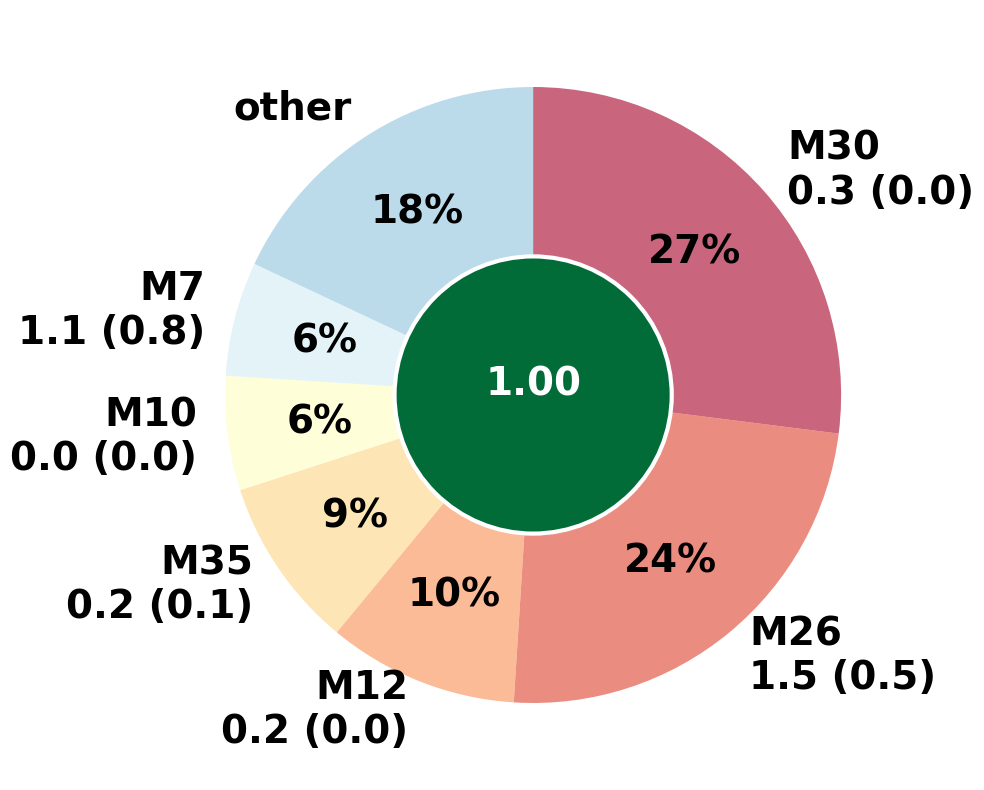

C:\Users\OMEN\AppData\Local\Temp\ipykernel_13004\1817222474.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ig_series = (df_grad[field_name].cumsum()/float(n_points)) * delta[field_name]


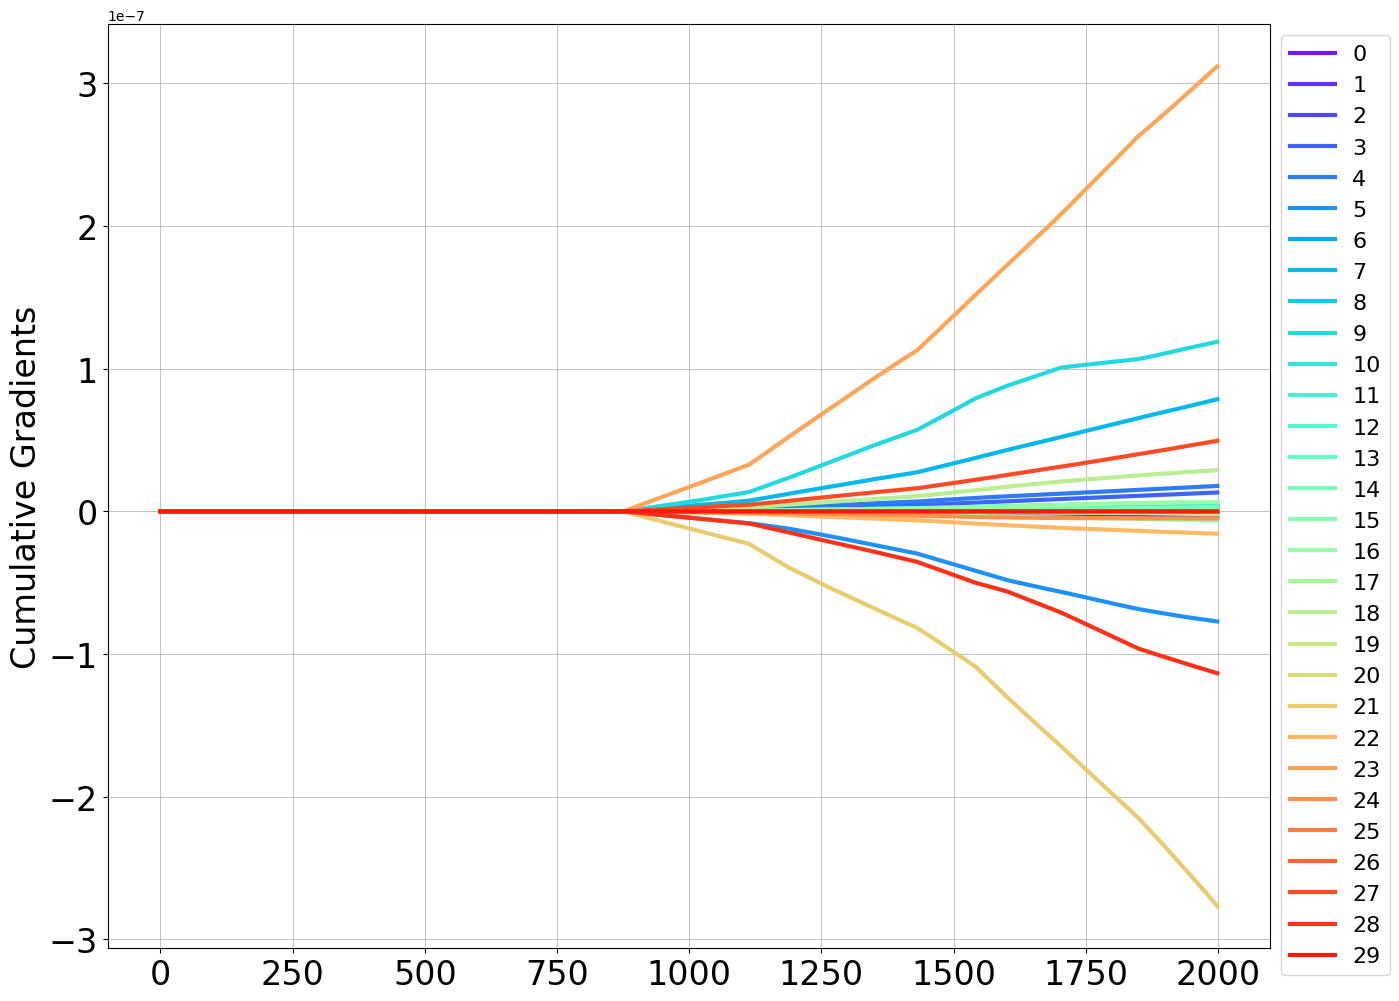

In [35]:
attribution = pd.Series(attribution_dict)
nearest_reference_point_normalized = pd.Series(reference_point_dict)
df_nearest_reference_point_normalized = nearest_reference_point_normalized.to_frame().T
df_nearest_reference_point = madi.utils.sample_utils.denormalize(df_nearest_reference_point_normalized, ad._normalization_info)
df_attribution = pd.concat([df_observed_point.iloc[0], df_nearest_reference_point.iloc[0], attribution], axis = 1,
                           keys=['observed_value', 'expected_value', 'attribution'], sort = True)

plot_attribution(df_attribution, anomaly_score)

# Plot the attribution as a cumulative curve from reference to observed.
# Use the normalized difference, b/c the model and its gradients are based on
# normalized training data.
delta_normalized = df_nearest_reference_point_normalized.iloc[0] - df_observed_point_normalized.iloc[0]
colnames  = {}
column_order = madi.utils.sample_utils.get_column_order(ad._normalization_info)
for i in range(len(column_order)):
  colnames[i] = column_order[i]

df_grad.set_axis(column_order, axis=1)# inplace=True omitted
plot_gradient_series(df_grad, delta_normalized)